In [ ]:
# Mrunal Waghmare 
# Deep Learining Lab
# 43572
# Assignmaent -4

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, recall_score, accuracy_score, precision_score

In [4]:
import pandas as pd  # Ensure pandas is imported

RANDOM_SEED = 2021
TEST_PCT = 0.3
LABELS = ['Normal', 'Fraud']  # Corrected the quotation marks

# Load the dataset
dataset = pd.read_csv("creditcard.csv")


In [12]:
#check for any null values
print("Any nulls in the dataset",dataset.isnull().values.any())
print("------------------------------------------")
print("No. of unique labels",len(dataset['Class'].unique()))
print("Label values",dataset.Class.unique())
#0 is for normal credit card transcation
#1 is for fraudulent credit card transcation
print("------------------------------------------")
print("Break down of Normal and Fraud Transcations")
print(pd.value_counts(dataset['Class'],sort=True))

Any nulls in the dataset False
------------------------------------------
No. of unique labels 2
Label values [0 1]
------------------------------------------
Break down of Normal and Fraud Transcations
Class
0    284315
1       492
Name: count, dtype: int64


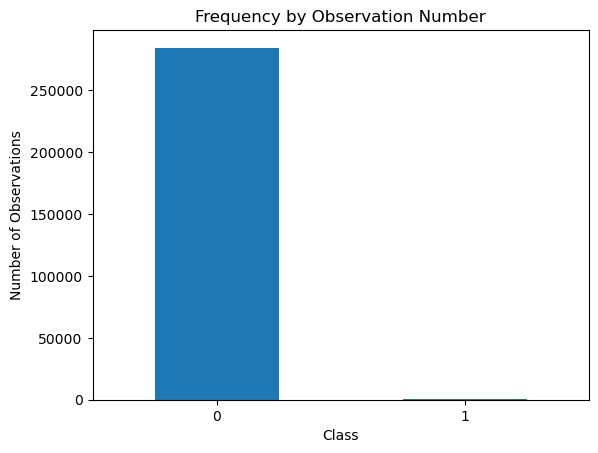

In [13]:
# Visualizing the imbalanced dataset
count_classes = pd.value_counts(dataset['Class'], sort=True)
count_classes.plot(kind='bar', rot=0)
plt.xticks(range(len(dataset['Class'].unique())), dataset['Class'].unique())
plt.title("Frequency by Observation Number")
plt.xlabel("Class")
plt.ylabel("Number of Observations")
plt.show()


In [14]:
# Save the normal and fraudulent transactions in separate dataframes
normal_dataset = dataset[dataset['Class'] == 0]
fraud_dataset = dataset[dataset['Class'] == 1]


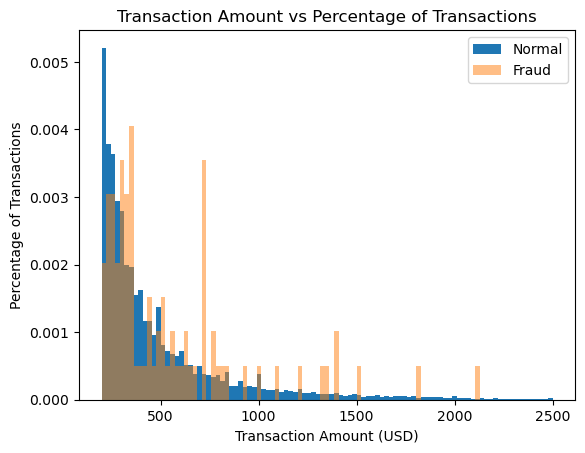

In [15]:
# Visualize transaction amounts for normal and fraudulent transactions
bins = np.linspace(200, 2500, 100)
plt.hist(normal_dataset.Amount, bins=bins, alpha=1, density=True, label='Normal')
plt.hist(fraud_dataset.Amount, bins=bins, alpha=0.5, density=True, label='Fraud')
plt.legend(loc='upper right')
plt.title("Transaction Amount vs Percentage of Transactions")
plt.xlabel("Transaction Amount (USD)")
plt.ylabel("Percentage of Transactions")
plt.show()


In [16]:
# Standardizing the 'Time' and 'Amount' columns
sc = StandardScaler()
dataset['Time'] = sc.fit_transform(dataset['Time'].values.reshape(-1, 1))
dataset['Amount'] = sc.fit_transform(dataset['Amount'].values.reshape(-1, 1))


In [18]:
# Extract raw data from the dataset
raw_data = dataset.values

# The last element contains whether the transaction is normal (0) or fraudulent (1)
labels = raw_data[:, -1]


In [19]:
from sklearn.model_selection import train_test_split
import tensorflow as tf

# The other data points are the features (excluding the labels)
data = raw_data[:, 0:-1]

# Split the dataset into training and testing sets (80% train, 20% test)
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.2, random_state=2021)

# Normalize the training data
min_val = tf.reduce_min(train_data)
max_val = tf.reduce_max(train_data)

train_data = (train_data - min_val) / (max_val - min_val)
test_data = (test_data - min_val) / (max_val - min_val)

# Cast the data to float32 for TensorFlow
train_data = tf.cast(train_data, tf.float32)
test_data = tf.cast(test_data, tf.float32)

# Convert labels to boolean
train_labels = train_labels.astype(bool)
test_labels = test_labels.astype(bool)


In [20]:
# Creating normal and fraud datasets
normal_train_data = train_data[~train_labels]  # Normal transactions in the training set
normal_test_data = test_data[~test_labels]      # Normal transactions in the testing set

fraud_train_data = train_data[train_labels]     # Fraudulent transactions in the training set
fraud_test_data = test_data[test_labels]         # Fraudulent transactions in the testing set

# Print the number of records in each dataset
print("No. of records in Fraud Train Data =", len(fraud_train_data))
print("No. of records in Normal Train Data =", len(normal_train_data))
print("No. of records in Fraud Test Data =", len(fraud_test_data))
print("No. of records in Normal Test Data =", len(normal_test_data))

# Model parameters
nb_epoch = 50
batch_size = 64
input_dim = normal_train_data.shape[1]  # Number of columns, e.g., 30
encoding_dim = 14
hidden_dim1 = int(encoding_dim / 2)
hidden_dim2 = 4
learning_rate = 1e-7


No. of records in Fraud Train Data = 389
No. of records in Normal Train Data = 227456
No. of records in Fraud Test Data = 103
No. of records in Normal Test Data = 56859


In [21]:
# c. Encoder converts it into latent representation

# Encoder
input_layer = tf.keras.layers.Input(shape=(input_dim,))  # Ensure you define the input layer

encoder = tf.keras.layers.Dense(encoding_dim, activation="tanh", activity_regularizer=tf.keras.regularizers.l2(learning_rate))(input_layer)
encoder = tf.keras.layers.Dropout(0.2)(encoder)
encoder = tf.keras.layers.Dense(hidden_dim1, activation='relu')(encoder)
encoder = tf.keras.layers.Dense(hidden_dim2, activation=tf.nn.leaky_relu)(encoder)


In [23]:
# d. Decoder networks convert it back to the original input
# Decoder
decoder = tf.keras.layers.Dense(hidden_dim1, activation='relu')(encoder)
decoder = tf.keras.layers.Dropout(0.2)(decoder)
decoder = tf.keras.layers.Dense(encoding_dim, activation='relu')(decoder)
decoder = tf.keras.layers.Dense(input_dim, activation='tanh')(decoder)

# Autoencoder
autoencoder = tf.keras.Model(inputs=input_layer, outputs=decoder)
autoencoder.summary()

# Checkpoint callback to save the best model
cp = tf.keras.callbacks.ModelCheckpoint(
    filepath="autoencoder_fraud.keras",  # Change the file extension to .keras
    mode='min',
    monitor='val_loss',
    verbose=2,
    save_best_only=True
)


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 30)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 14)                  │             434 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 14)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 7)                   │             105 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 4)                   │              32 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 7)                   │              35 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 7)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 14)                  │             112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 30)                  │             450 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,168 (4.56 KB)

 Trainable params: 1,168 (4.56 KB)

 Non-trainable params: 0 (0.00 B)

In [25]:
# Define our early stopping
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0.0001,
    patience=10,
    verbose=1,  # Change verbose to 1 for normal output
    mode='min',
    restore_best_weights=True
)
# e. Compile the model with optimizer, loss, and evaluation metrics
autoencoder.compile(metrics=['accuracy'], loss='mean_squared_error', optimizer='adam')

# Fit the model
history = autoencoder.fit(
    normal_train_data,
    normal_train_data,
    epochs=nb_epoch,
    batch_size=batch_size,
    shuffle=True,
    validation_data=(test_data, test_data),
    verbose=1,
    callbacks=[cp, early_stop]
).history


Epoch 1/50
3545/3554 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0383 - loss: 0.0186
Epoch 1: val_loss improved from inf to 0.00002, saving model to autoencoder_fraud.keras
3554/3554 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.0383 - loss: 0.0186 - val_accuracy: 0.0220 - val_loss: 2.3452e-05
Epoch 2/50
3532/3554 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0663 - loss: 1.9533e-05
Epoch 2: val_loss did not improve from 0.00002
3554/3554 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.0663 - loss: 1.9531e-05 - val_accuracy: 0.0215 - val_loss: 2.4102e-05
Epoch 3/50
3541/3554 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0629 - loss: 1.9119e-05
Epoch 3: val_loss did not improve from 0.00002
3554/3554 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.0629 - loss: 1.9120e-05 - val_accuracy: 0.0189 - val_loss: 2.5265e-05
Epoch 4/50
3543/3554 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0662 - loss: 1.8940e-05
Epoch 4: val_loss did not improve from 0.00002
3554/3554 ━━━━━━━━━━━━━━━━━━━

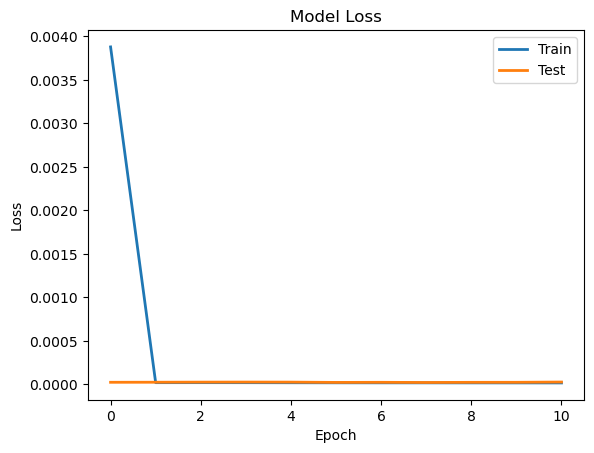

In [26]:
import matplotlib.pyplot as plt  # Ensure you have imported matplotlib

# Plot the training and validation loss
plt.plot(history['loss'], linewidth=2, label='Train')
plt.plot(history['val_loss'], linewidth=2, label='Test')
plt.legend(loc='upper right')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')

# Optionally set y-axis limits (uncomment if needed)
# plt.ylim(ymin=0.70, ymax=1)

plt.show()


1781/1781 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


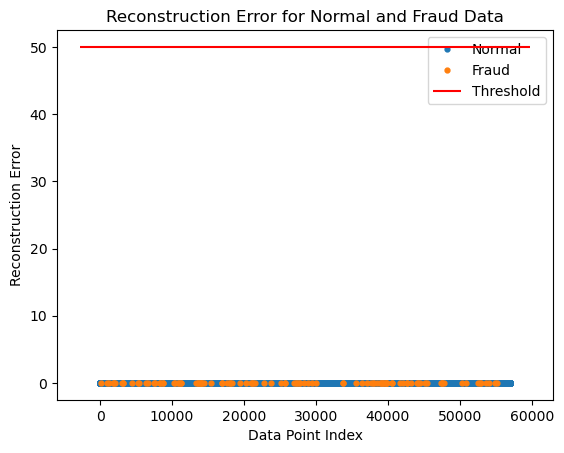

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Make predictions on the test data
test_x_predictions = autoencoder.predict(test_data)

# Calculate the Mean Squared Error (MSE) for reconstruction
mse = np.mean(np.power(test_data - test_x_predictions, 2), axis=1)

# Create a DataFrame with reconstruction errors and true class labels
error_df = pd.DataFrame({
    'Reconstruction_error': mse,
    'True_class': test_labels
})

# Define a fixed threshold for classification
threshold_fixed = 50
groups = error_df.groupby('True_class')

# Plotting
fig, ax = plt.subplots()

# Plot reconstruction errors for each class
for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label="Fraud" if name == 1 else "Normal")

# Draw a horizontal line for the threshold
ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label="Threshold")

# Add legend and labels
ax.legend()
plt.title("Reconstruction Error for Normal and Fraud Data")
plt.ylabel("Reconstruction Error")
plt.xlabel("Data Point Index")
plt.show()


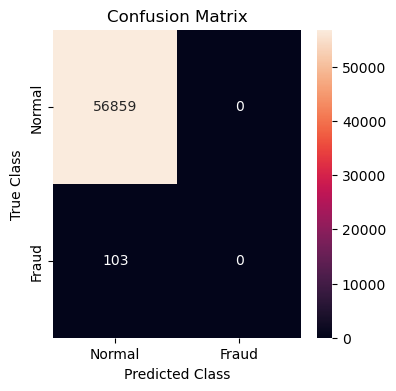

Accuracy : 0.9981917769741231
Recall : 0.0
Precision : 0.0


In [31]:
# Set the threshold for classification (try lowering it)
threshold_fixed = 30  # Adjusted threshold value

# Generate predictions based on reconstruction error
pred_y = [1 if e > threshold_fixed else 0 for e in error_df.Reconstruction_error.values]
error_df['pred'] = pred_y

# Create confusion matrix
conf_matrix = confusion_matrix(error_df.True_class, pred_y)

# Plot confusion matrix
plt.figure(figsize=(4, 4))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d")
plt.title("Confusion Matrix")
plt.ylabel("True Class")
plt.xlabel("Predicted Class")
plt.show()

# Print Accuracy, Precision, and Recall
print("Accuracy :", accuracy_score(error_df['True_class'], error_df['pred']))
print("Recall :", recall_score(error_df['True_class'], error_df['pred']))
print("Precision :", precision_score(error_df['True_class'], error_df['pred'], zero_division=0))  # Set zero_division to 0
